## Анализ процесса электронно-лучевой сварки

### Подключение необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

### Загрузка исходного датасета
<b>ВХОД:</b>
<ol>
    <li>IW - Ток сварочного тока</li>
    <li>IF - Ток фокусировки электронного пучка</li>
    <li>VW - Скорость сварки</li>
    <li>FP - Расстояние от поверхности образцов</li>
</ol>
<br>
<b>ВЫХОД:</b>
<ol>
    <li>Depth - Глубина шва</li>
    <li>Width - Ширина шва</li>
</ol>

In [2]:
rawData = pd.read_csv('ebw_data.csv')

### Предварительная обработка и разведовательный анализ

##### Просмотр первых строк датасета

In [3]:
rawData.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


##### Проверка на наличие пропусков

In [4]:
rawData.isnull().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

##### Построение обучающей выборки
Анализ датасета показывает, что комбинации значений столбцов IW, IF, VW, FP повторяются. Поэтому построим новый датасет, с уникальными комбинациями признаков и выходным параметром усредненным по каждой группе

In [5]:
trainData = rawData.groupby(['IW', 'IF', 'VW', 'FP']).agg({'Depth': ['mean'], 'Width': ['mean']}).reset_index()
trainData.columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']

In [6]:
# Модифицированный датасет для обучения
trainData

,IW,IF,VW,FP,Depth,Width
0,43,146,9.0,60,1.220,1.7650
1,43,150,9.0,50,1.080,1.8150
2,44,146,9.0,60,1.230,1.7950
3,45,140,4.5,80,1.690,2.5100
4,45,140,8.0,80,1.190,1.9700
5,45,141,10.0,80,1.010,1.8600
6,45,146,9.0,60,1.310,1.7600
7,46,141,10.0,80,1.140,1.8200
8,46,146,10.0,60,1.310,1.7700
9,47,134,10.0,110,0.945,1.9350


##### Описательная статистика

In [7]:
trainData.describe()

,IW,IF,VW,FP,Depth,Width
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,45.800000,140.866667,8.866667,80.666667,1.171000,1.957500
std,1.740279,5.462426,2.021904,23.057898,0.229543,0.265678
min,43.000000,131.000000,4.500000,50.000000,0.820000,1.727500
25%,45.000000,139.500000,8.500000,60.000000,1.045000,1.780000
50%,46.000000,141.000000,9.000000,80.000000,1.160000,1.820000
75%,47.000000,146.000000,10.000000,80.000000,1.270000,2.020000
max,49.000000,150.000000,12.000000,125.000000,1.690000,2.515000


##### Расчет корреляционной матрицы
В случае линейной регрессионной модели корреляционная матрица позволит выяснить, какие признаки в большей степени влияют на целевую переменную

In [8]:
# Корреляционная матрица
trainData.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.844566,0.073079,0.831286,-0.389267,0.359959
IF,-0.844566,1.000000,0.066182,-0.983178,0.452146,-0.501293
VW,0.073079,0.066182,1.000000,0.017364,-0.651087,-0.864309
FP,0.831286,-0.983178,0.017364,1.000000,-0.569981,0.432293
Depth,-0.389267,0.452146,-0.651087,-0.569981,1.000000,0.355843
Width,0.359959,-0.501293,-0.864309,0.432293,0.355843,1.000000


##### Корреляционная матрица в виде тепловой карты

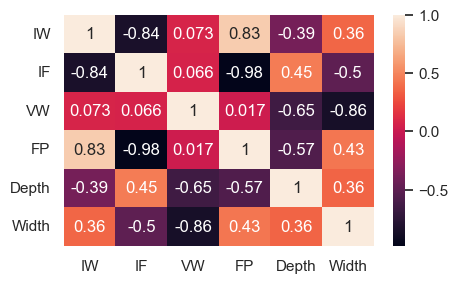

In [9]:
plt.figure(figsize = (5, 3), dpi = 100)
sns.heatmap(trainData.corr(), annot = True)
plt.show()

##### Разбиваем выборку на массив признаков и вектор со значениями целевой переменной

In [10]:
# Признаки
X = trainData.iloc[:, 0:4]
# Глубина шва
yD = trainData.iloc[:, 4:5]
# Ширина шва
yW = trainData.iloc[:, 5:6]

In [11]:
# Матрица признаков
X.head()

,IW,IF,VW,FP
0,43,146,9.0,60
1,43,150,9.0,50
2,44,146,9.0,60
3,45,140,4.5,80
4,45,140,8.0,80


In [12]:
# Вектор целевая переменная - Глубина шва
yD.head()

,Depth
0,1.22
1,1.08
2,1.23
3,1.69
4,1.19


In [13]:
# Вектор целевая переменная - Ширина шва
yW.head()

,Width
0,1.765
1,1.815
2,1.795
3,2.510
4,1.970


In [14]:
print('Размерности данных')
print(f'Матрица признаков {X.shape}')
print(f'Целевой вектор (глубина шва) {yD.shape}')
print(f'Целевой вектор (ширина шва) {yW.shape}')

Размерности данных
Матрица признаков (15, 4)
Целевой вектор (глубина шва) (15, 1)
Целевой вектор (ширина шва) (15, 1)


##### Разбивка данных на выборки для обучения и тестирования

In [15]:
X_train = pd.DataFrame(trainData.iloc[:, 0:4]).values
yD_train = pd.DataFrame(trainData.iloc[:, 4:5]).values
yW_train = pd.DataFrame(trainData.iloc[:, 5:6]).values

X_test = pd.DataFrame(rawData.iloc[:, 0:4]).values
yD_test = pd.DataFrame(rawData.iloc[:, 4:5]).values
yW_test = pd.DataFrame(rawData.iloc[:, 5:6]).values

Model score: 0.943


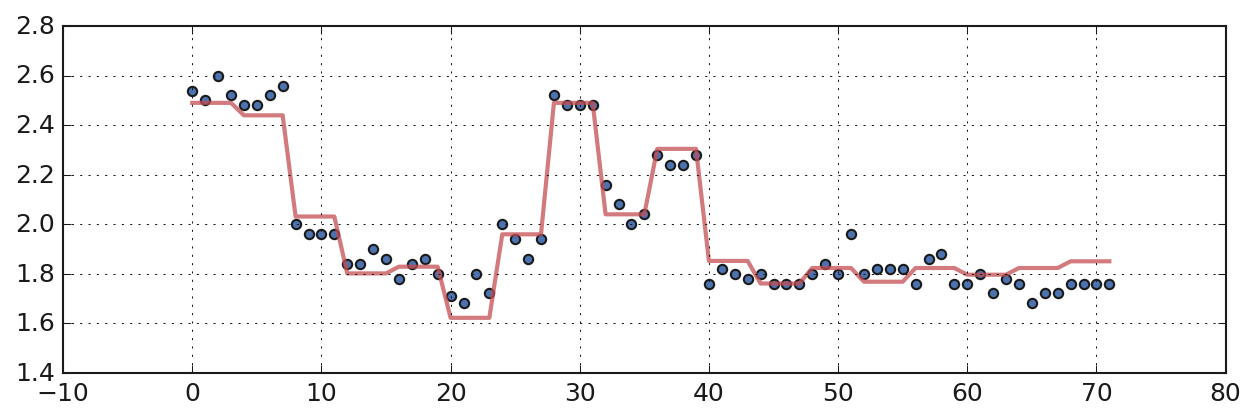

In [16]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, yW_train)
print(f'Model score: {pipe.score(X_test, yW_test):0.3}')
yW_predict = pipe.predict(X_test)
xW_predict = range(yW_predict.shape[0])

plt.figure(figsize = (10, 3), dpi = 150)
plt.style.use('classic')
plt.scatter(xW_predict, yW_test)
plt.plot(xW_predict, yW_predict, '-r',  linewidth = 2, alpha = .75)
plt.grid()
plt.show()

Model score: 0.976


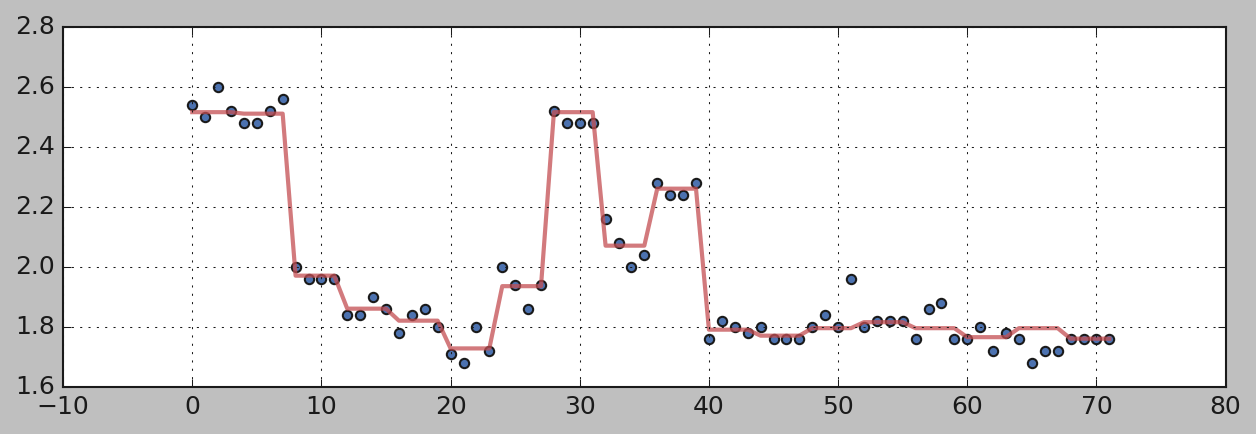

In [17]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
pipe.fit(X_train, yW_train)
print(f'Model score: {pipe.score(X_test, yW_test):0.3}')
yW_predict = pipe.predict(X_test)
xW_predict = range(yW_predict.shape[0])

plt.figure(figsize = (10, 3), dpi = 150)
plt.style.use('classic')
plt.scatter(xW_predict, yW_test)
plt.plot(xW_predict, yW_predict, '-r',  linewidth = 2, alpha = .75)
plt.grid()
plt.show()

Model score: 0.804


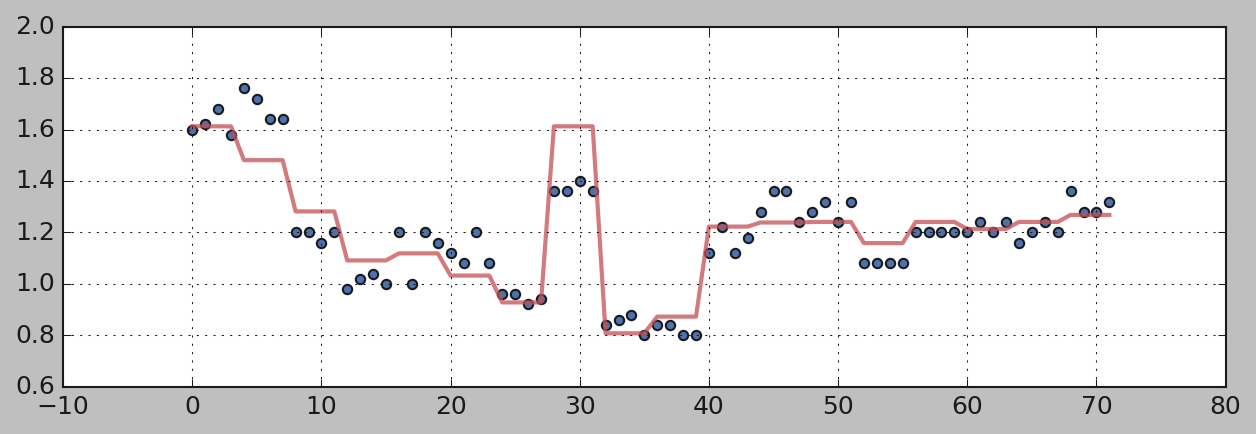

In [18]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, yD_train)
print(f'Model score: {pipe.score(X_test, yD_test):0.3}')
yD_predict = pipe.predict(X_test)
xD_predict = range(yD_predict.shape[0])

plt.figure(figsize = (10, 3), dpi = 150)
plt.style.use('classic')
plt.scatter(xD_predict, yD_test)
plt.plot(xD_predict, yD_predict, '-r',  linewidth = 2, alpha = .75)
plt.grid()
plt.show()

Model score: 0.933


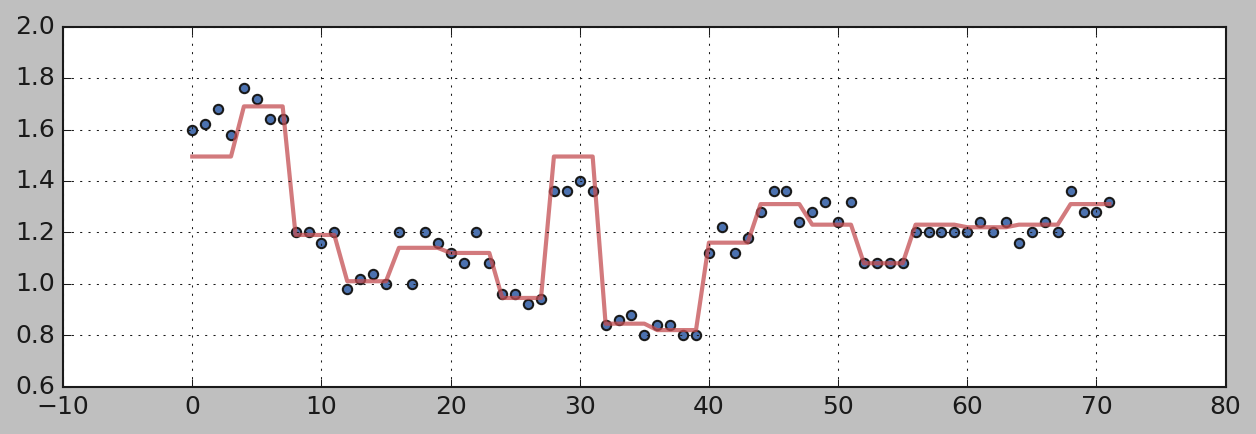

In [19]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
pipe.fit(X_train, yD_train)
print(f'Model score: {pipe.score(X_test, yD_test):0.3}')
yD_predict = pipe.predict(X_test)
xD_predict = range(yD_predict.shape[0])

plt.figure(figsize = (10, 3), dpi = 150)
plt.style.use('classic')
plt.scatter(xD_predict, yD_test)
plt.plot(xD_predict, yD_predict, '-r',  linewidth = 2, alpha = .75)
plt.grid()
plt.show()